# Petermann Heat Transport

Use icepack HeatTransport model to obtain a Petermann system in thermal equilibrium from RACMO2 surface temp and Martos geothermal flux data (flowline model)

## Setup

In [1]:
import sys 
import glob
import os

import matplotlib.pyplot as plt
import numpy as np

import rioxarray as rxr
import xarray as xr
import rasterio

import geojson

import firedrake
import icepack
import icepack.plot

fatal: detected dubious ownership in repository at '/mnt/data01/Code/OtherRepos/firedrake/src/PyOP2'
To add an exception for this directory, call:

	git config --global --add safe.directory /mnt/data01/Code/OtherRepos/firedrake/src/PyOP2
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


### Mesh

In [2]:
### Load basin outline
outline_fn = '../../Petermann-xyplane/InitialConditions/petermann_streamlines_evenspace_full.geojson'

with open(outline_fn, 'r') as outline_file:
    basin_outline = geojson.load(outline_file)
    
basin_coords = []
for i in basin_outline['features'][0]['geometry']['coordinates']:
    for coord in i:
        basin_coords.append(coord)
basin_coords=np.array(basin_coords)

### Load flowline file
new_fn_nc = 'Petermann-centerline.nc'
flowline = xr.open_dataset(new_fn_nc)

In [3]:
# Establish mesh, function spaces, and vector spaces that variables will live on in the mesh
ld=flowline['linedist'][0]
Lx = np.int(np.round(ld[-1]))
nx = np.int(np.round(ld[-1]/1000))

mesh1d = firedrake.IntervalMesh(nx, Lx)
mesh = firedrake.ExtrudedMesh(mesh1d, layers=1)

Q = firedrake.FunctionSpace(
    mesh, family='CG', degree=2,
    vfamily='R', vdegree=0
)

V = firedrake.FunctionSpace(
    mesh, family='CG', degree=2,
    vfamily='GL', vdegree=2
)

# Define spatial coordinates on the mesh
x, ζ = firedrake.SpatialCoordinate(mesh)

### Load/Interpolate Raster Data

In [4]:
### Reading data
root_ddir = '/mnt/data01/Data/'
thesis_dir = '/mnt/data01/User_Scratch/wdienstfrey24/Thesis/'

velocity_fn = glob.glob(root_ddir+'Greenland_Velocity/*.nc')
ice_info_fn = glob.glob(root_ddir+'Greenland_BedElevation/*.nc')[0]
hillshade_fn = glob.glob(root_ddir+'Greenland_Imagery/*.nc') 
hs = xr.open_dataset(hillshade_fn[0])
geothermal_fn = glob.glob(root_ddir+'Greenland_OtherData/Martos*.nc')
racmo_fn = glob.glob(thesis_dir+'Petermann-HeatFlow/*average.nc')

vx = rxr.open_rasterio(velocity_fn[0])[0,:,:]
vy = rxr.open_rasterio(velocity_fn[1])[0,:,:]
vz=vy.copy()
vz.values=np.zeros(np.shape(vy.values))
speed=np.sqrt(vx**2+vy**2)

ice_bed_props = rxr.open_rasterio(ice_info_fn)
thickness = ice_bed_props['thickness'][0,:,:]
bed = ice_bed_props['bed'][0,:,:]
surface = ice_bed_props['surface'][0,:,:]

geothermal = xr.open_rasterio(geothermal_fn[0])[0,:,:]/1000
racmo = xr.open_dataset(racmo_fn[0])
surftemp = racmo['T2m_avg']
SMB = racmo['SMB_avg']

In [5]:
####### Here we interpolate onto the mesh
h0 = icepack.interpolate_xr(flowline['Thickness'], Q)
s0 = icepack.interpolate_xr(flowline['Surface'], Q)
b = icepack.interpolate_xr(flowline['Bed'], Q)
u0 = icepack.interpolate_xr(flowline['Speed'], V)
gt0 = icepack.interpolate_xr(flowline['Geothermal'], Q)
st0 = icepack.interpolate_xr(flowline['SurfTemp'], Q)

h_in = h0.at([0,0])
s_in = s0.at([0,0])
u_in = u0.at([0,0])
s_out = s0.at([Lx,0])

### Plotting Functions

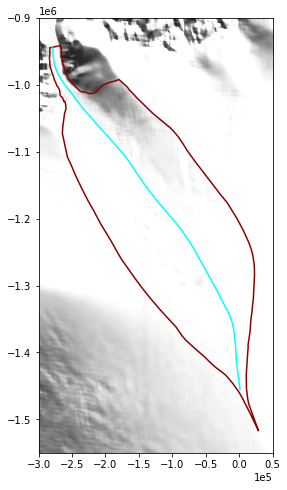

In [6]:
def basin_subplot(*args, **kwargs):
    zoom = kwargs.get("zoom",0)
    image = kwargs.get("image",0)
    
    fig, ax = plt.subplots(figsize=[8,8])
    im1=ax.imshow(hs['hillshade'].values,
                  extent=[hs['x'].values.min(),hs['x'].values.max(),hs['y'].values.min(),hs['y'].values.max()],
                  cmap='Greys_r', vmin=0,vmax=200,origin='upper')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    plt.plot(basin_coords.T[0],basin_coords.T[1],c='darkred')
    
    if zoom == -1:
        ax.set_ylim([-1.6e6,-1e6]);
        ax.set_xlim([-0.325e6,0.1e6]);
    elif zoom == 0:
        ax.set_ylim([-1.55e6,-.9e6]);
        ax.set_xlim([-0.3e6,0.05e6]);
    elif zoom == 1:
        ax.set_ylim(-1.1e6,-0.9e6);
        ax.set_xlim(-3e5,-1.5e5);

    ax.set_aspect('equal')
    
    return fig, ax

fig,ax = basin_subplot()
ax.plot(flowline['x_pol'][0],flowline['y_pol'][0],c='cyan');

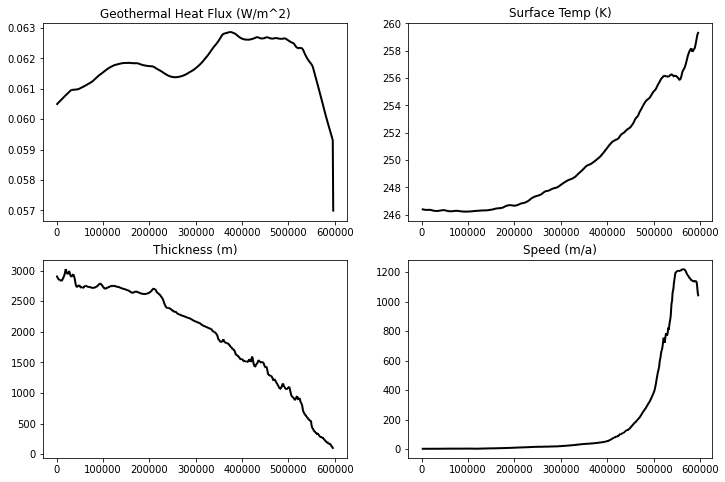

In [9]:
def depth_avg_plot(h0,u0,gt0,st0):
    fig, ax = plt.subplots(2,2)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    firedrake.plot(icepack.depth_average(gt0),axes=ax[0,0])
    firedrake.plot(icepack.depth_average(h0),axes=ax[1,0])
    firedrake.plot(icepack.depth_average(st0),axes=ax[0,1])
    firedrake.plot(icepack.depth_average(u0),axes=ax[1,1])
    ax[0,0].set_title('Geothermal Heat Flux (W/m^2)')
    ax[0,1].set_title('Surface Temp (K)')
    ax[1,0].set_title('Thickness (m)')
    ax[1,1].set_title('Speed (m/a)')
    return fig, ax

depth_avg_plot(h0,u0,gt0,st0);

In [10]:
def glacier_z_coords(var, h, s, b, field, xsampling=200, zsampling=100):
    x_opts = np.linspace(0.001,Lx-0.001,xsampling)
    ζ_opts = np.linspace(0.001,0.999,zsampling)
    x_coords_grid,ζ_coords_grid=np.meshgrid(x_opts,ζ_opts)

    orig_size = x_coords_grid.shape
    x_coords_vec = np.reshape(x_coords_grid,[1,np.prod(orig_size)])
    ζ_coords_vec = np.reshape(ζ_coords_grid,[1,np.prod(orig_size)])

    coord_list = np.concatenate([x_coords_vec,ζ_coords_vec]).T

    var_extract = []

    for i in coord_list:
        var_extract.append(var.at(i[0],i[1]))

    var_extract_vec = np.array(var_extract)
    var_extract_grid = np.reshape(var_extract,orig_size)

    surf = np.array(icepack.depth_average(s).at(x_opts))
    bed = np.array(icepack.depth_average(b).at(x_opts))
    ice_base = firedrake.interpolate(s - h, field)
    ice_base = np.array(icepack.depth_average(ice_base).at(x_opts))

    z_coords_grid = np.matmul(np.matrix(ζ_opts).T,np.matrix(surf-ice_base))+np.tile(ice_base,(zsampling,1))
    
    return(var_extract_grid, surf, bed, ice_base, x_opts, x_coords_grid, z_coords_grid)

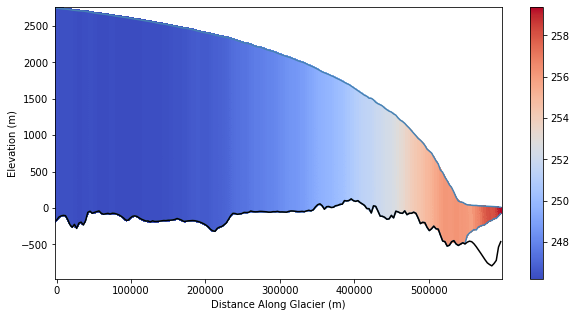

In [11]:
def glacier_plot(var, h, s, b, field, **kwargs):
    xsampling = kwargs.get("xsampling",200)
    zsampling = kwargs.get("ysampling",100)
    fsize = kwargs.get("figsize",(10,5))
    cmap = kwargs.get("cmap")
    vmin = kwargs.get("vmin")
    vmax = kwargs.get("vmax")
    
    (var_extract_grid, surf, bed, ice_b, x_opts, x_coords_grid, z_coords_grid) = glacier_z_coords(var, h, s, b, field, xsampling, zsampling)
    
    fig, ax = plt.subplots(figsize=fsize)

    cdata = plt.pcolor(x_coords_grid,z_coords_grid,var_extract_grid,
                       cmap=cmap,vmin=vmin,vmax=vmax)
    cbar = plt.colorbar(cdata)
    plt.plot(x_opts,surf,c='steelblue')
    plt.plot(x_opts,ice_b,c='steelblue')
    plt.plot(x_opts,bed,c='black')

    plt.xlabel('Distance Along Glacier (m)')
    plt.ylabel('Elevation (m)')
    return fig, ax
initial_glacier=glacier_plot(st0,h0,s0,b,Q,cmap='coolwarm')

## Modeling

In [12]:
heat_model = icepack.models.HeatTransport3D()
heat_solver = icepack.solvers.HeatTransportSolver(heat_model)

#Δ = firedrake.FunctionSpace(mesh, family='DG', degree=1)
#E = firedrake.Function(Δ)

In [13]:
from icepack.constants import (
    ice_density as ρ_I,
    year as year,
    thermal_diffusivity as α,
    heat_capacity as c,
    latent_heat as L,
    melting_temperature as Tm)

### Initial guess of the glacier temperature
ice_t = firedrake.Constant(200)
f = firedrake.Constant(0.)

E_surf = firedrake.interpolate(heat_model.energy_density(st0,f),Q)
E_geo = firedrake.interpolate(gt0,Q)

In [15]:
import tqdm
final_time = 400.
num_timesteps = 400
dt = final_time / num_timesteps

E_0 = heat_model.energy_density(ice_t,f)
E_0 = firedrake.interpolate(E_0,Q)
E = E_0.copy(deepcopy=True)

Es=[E_0]

for step in tqdm.trange(num_timesteps):
    E = heat_solver.solve(
        dt=dt,
        energy=E,
        velocity=u0,
        vertical_velocity=firedrake.Constant(0.),
        thickness=h0,
        energy_inflow=firedrake.Constant(0.),
        energy_surface=E_surf,
        heat_bed=gt0,
        heat=firedrake.Constant(0.)
    )
    Es.append(E)

  0%|          | 0/400 [00:00<?, ?it/s]


IndexError: tuple index out of range

## Analysis

In [ ]:
import NDH_Tools as ndh

In [ ]:
T_fin = firedrake.interpolate(heat_model.temperature(E),Q)
initial_glacier=glacier_plot(st0,h0,s0,b,Q,cmap='coolwarm')